# 2022-01-27 Example time series plots for the deterministic models

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/1094876938495c2ccff530b6738969a12fc03f61

(Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

Starting to work towards some paper-presentable plots - starting with some example plots of the deterministic models, but also some new model insights below...

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
    sys.path.append(parent_path + '/SCPaper')
print(sys.path)

# imports needed to run the simulations
import os, contextlib
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import parameter_search
import sc_scenario
import sc_fitting
import sc_plot
import do_2_analyse_deterministic_fits
from do_2_analyse_deterministic_fits import CRITERIA, i_MAIN


@dataclass
class ScenarioPlotInfo():
    end_time: int
    metric_max: bool


PLOT_INFO = {}
PLOT_INFO['VehPrioAssert'] = ScenarioPlotInfo(end_time=3, metric_max=True)
PLOT_INFO['VehShortStop'] = ScenarioPlotInfo(end_time=10, metric_max=True)
PLOT_INFO['PedHesitateVehConst'] = ScenarioPlotInfo(end_time=9, metric_max=False)
PLOT_INFO['PedHesitateVehYield'] = ScenarioPlotInfo(end_time=8, metric_max=False)
PLOT_INFO['PedCrossVehYield'] = ScenarioPlotInfo(end_time=6, metric_max=True)


# run do_2... without any stdout (https://stackoverflow.com/questions/2828953/silence-the-stdout-of-a-function-in-python-without-trashing-sys-stdout-and-resto)
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        det_fits = do_2_analyse_deterministic_fits.do()


# get indices of parameterisations with max number of met main criteria for model
def get_max_crit_parameterisations(fit):
    n_max_crit_met = np.amax(fit.n_main_criteria_met)
    return np.nonzero(fit.n_main_criteria_met == n_max_crit_met)[0]

# plot simulations for an example model parameterisation
def plot_example(fit, idx_example):
    params_array = fit.results.params_matrix[idx_example, :]
    params_dict = fit.get_params_dict(params_array)
    print(params_dict)
    print(dict(zip(CRITERIA[0], fit.main_criteria_matrix[:, idx_example])))
    print(dict(zip(CRITERIA[1], fit.sec_criteria_matrix[:, idx_example])))
    beh_est = 'oBE' in fit.name
    if beh_est:
        nrows = 4
    else:
        nrows = 3
    fig, axs = plt.subplots(nrows = nrows, ncols = len(sc_fitting.ONE_AG_SCENARIOS),
                           sharex='col', sharey='row', figsize=(10, 4))
    for i_scenario, scenario in enumerate(sc_fitting.ONE_AG_SCENARIOS.values()):
        print(f'*** {scenario.name}')
        
        # figure out which kinematic variant to use
        metric_name = sc_fitting.ONE_AG_SCENARIOS[scenario.name].full_metric_names[0]
        metric_vals = fit.get_metric_results(metric_name)
        ex_metric_vals = metric_vals[idx_example, :]
        print(ex_metric_vals)
        if np.all(np.isnan(ex_metric_vals)):
            i_variation = 0
        else:
            if PLOT_INFO[scenario.name].metric_max:
                i_variation = np.nanargmax(ex_metric_vals)
            else:
                i_variation = np.nanargmin(ex_metric_vals)
                
        # run simulation
        scenario.end_time = PLOT_INFO[scenario.name].end_time
        sim = sc_fitting.construct_model_and_simulate_scenario(
            model_name=fit.name, params_dict=params_dict, scenario=scenario,
        i_variation = i_variation, apply_stop_criteria=False)
        
        # get the active agent and set colours
        act_agent = None
        for agent in sim.agents:
            if agent.const_acc == None:
                act_agent = agent
                break
        act_agent.plot_color = sc_plot.COLORS['active agent blue']
        act_agent.other_agent.plot_color = sc_plot.COLORS['passive agent grey']
        
        # plot kinematic states
        this_axs = axs[0:3, i_scenario]
        sim.do_kinem_states_plot(axs=this_axs, veh_stop_dec=(scenario.name=='VehShortStop'),
                                axis_labels=(i_scenario==0))
        sc_fitting.get_metrics_for_scenario(scenario, sim, verbose=True)
        
        # plot behaviour probabilities if and as appropriate
        if beh_est:
            BEH_PLOT_COLORS = ('blue', sc_plot.COLORS['other passes first red'], 
                               sc_plot.COLORS['other passes second green'])
            if 'oBEc' in fit.name:
                behs = (sc_scenario.i_CONSTANT, sc_scenario.i_PASS1ST, sc_scenario.i_PASS2ND)
            else:
                behs = (sc_scenario.i_PASS1ST, sc_scenario.i_PASS2ND)
            if 'oAI' in fit.name:
                acts = act_agent.i_no_action + np.array((-1, 1))
                act_ls = (':', '-')
                ylabel = '$P_{b|a}$ (-)'
            else:
                acts = (act_agent.i_no_action,)
                act_ls = ('-')
                ylabel = '$P_b$ (-)'
            for i_beh, beh in enumerate(behs):
                for i_act, act in enumerate(acts):
                    axs[-1, i_scenario].plot(sim.time_stamps, act_agent.states.beh_probs_given_actions[beh, act, :],
                                            c=BEH_PLOT_COLORS[beh], ls=act_ls[i_act])
            if i_scenario == 0:
                axs[-1, 0].set_ylabel(ylabel)   
        axs[-1, i_scenario].set_xlabel('Time (s)')

['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework', 'C:\\GITHUB\\COMMOTIONSFramework/SCPaper']


## Base model


{'k_c': 0.25830993300297683, 'k_sc': 0.020000000000000004}
{'Vehicle asserting priority': False, 'Vehicle short-stopping': False, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': True}
{'Pedestrian hesitation in constant-speed scenario': False}
*** VehPrioAssert
[13.88888889 13.88888889 13.88888889]
Metric VehPrioAssert_veh_av_speed = 13.88888888888889
*** VehShortStop
[0.36180262 0.1221355  0.2852244 ]
Metric VehShortStop_veh_av_surpl_dec = 0.3618026197182067
*** PedHesitateVehConst
[1.3 1.3 1.3]
Metric PedHesitateVehConst_ped_av_speed = 1.3
*** PedHesitateVehYield
[1.10555556 1.3        1.3       ]
Metric PedHesitateVehYield_ped_av_speed = 1.1055555555555554
*** PedCrossVehYield
[13.40258326 13.52869986 13.60287388]
Metric PedCrossVehYield_veh_speed_at_ped_start = 13.60287387882116


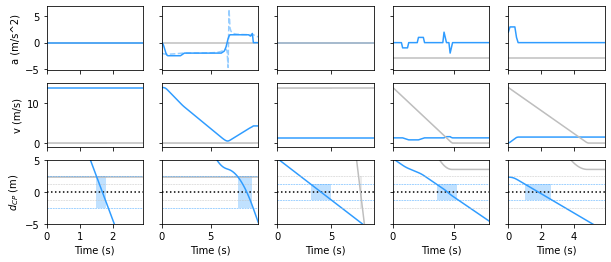

In [2]:
fit = det_fits['']
idx_best = get_max_crit_parameterisations(fit)
plot_example(fit, idx_example=idx_best[0])

## `oBEo`

It's actually able to add the gap acceptance hesitation criterion to the other two already achieved by the base model just above. (I thought it might stop doing one or both of those.)

Also of note below: None of the three stored results for `PedHesitateVehConst_ped_av_speed` across the kinematic variants match exactly the value I get in the simulation below for that scenario. So there seems to be possibilities for slight differences in results between ARC4 and my computer. I am happy to see though that everywhere else in this notebook, I am getting identical results to those saved from the ARC4 runs.

[1.26875    1.         1.21176471]
{'k_c': 2.0, 'k_sc': 0.020000000000000004, 'T_Of': 0.5, 'sigma_O': 0.43088693800637673}
{'Vehicle asserting priority': False, 'Vehicle short-stopping': False, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': True}
{'Pedestrian hesitation in constant-speed scenario': True}
*** VehPrioAssert
[13.88888889 13.88888889 13.88888889]
Metric VehPrioAssert_veh_av_speed = 13.88888888888889
*** VehShortStop
[0.3916182  0.14500681 0.2852244 ]
Metric VehShortStop_veh_av_surpl_dec = 0.39161820010457027
*** PedHesitateVehConst
[1.26875    1.         1.21176471]
Metric PedHesitateVehConst_ped_av_speed = 1.088888888888889
*** PedHesitateVehYield
[0.86521739 0.8375     0.8375    ]
Metric PedHesitateVehYield_ped_av_speed = 0.8374999999999998
*** PedCrossVehYield
[13.40258326 12.44813278 13.60287388]
Metric PedCrossVehYield_veh_speed_at_ped_start = 13.60287387882116


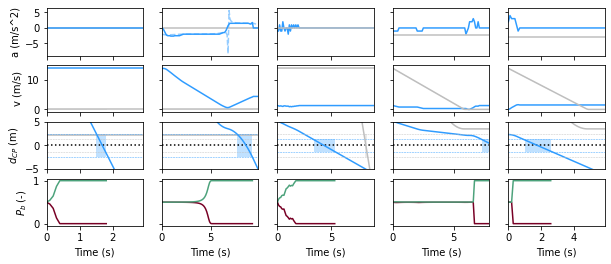

In [3]:
def get_min_ped_hes_speed_example(fit): 
    hes_speeds = fit.get_metric_results('PedHesitateVehConst_ped_av_speed')
    min_hes_speeds = np.amin(hes_speeds, axis=1)
    idx_example = np.argmin(min_hes_speeds)
    print(hes_speeds[idx_example, :])
    return idx_example

fit = det_fits['oBEo']
idx_example = get_min_ped_hes_speed_example(fit)
plot_example(fit, idx_example)

## `oBEvoAI`

Does not achieve neither priority assertion nor short-stopping. I am a little unsure of the exact reasons for both of these still, for example I need to understand if the safety margins included in calculating the behaviour accelerations mean that the agents are very rarely on a collision course with each other after the action prediction interval. To do that requires slight restructuring of the value calculation code, though, to see better in snapshots what's happening, so I first want to commit the results here, to give me something recent to compare to later to make sure I haven't messed up.

{'k_c': 0.4308869380063768, 'k_sc': 0.020000000000000004, 'beta_V': 1.0}
{'Vehicle asserting priority': False, 'Vehicle short-stopping': False, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': True}
{'Pedestrian hesitation in constant-speed scenario': False}
*** VehPrioAssert
[13.88888889 13.88888889 13.88888889]
Metric VehPrioAssert_veh_av_speed = 13.88888888888889
*** VehShortStop
[0.3916182  0.14500681 0.2852244 ]
Metric VehShortStop_veh_av_surpl_dec = 0.39161820010457027
*** PedHesitateVehConst
[1.3 1.3 1.3]
Metric PedHesitateVehConst_ped_av_speed = 1.3
*** PedHesitateVehYield
[1.025 1.3   1.3  ]
Metric PedHesitateVehYield_ped_av_speed = 1.025
*** PedCrossVehYield
[13.40258326 13.52869986 13.60287388]
Metric PedCrossVehYield_veh_speed_at_ped_start = 13.60287387882116


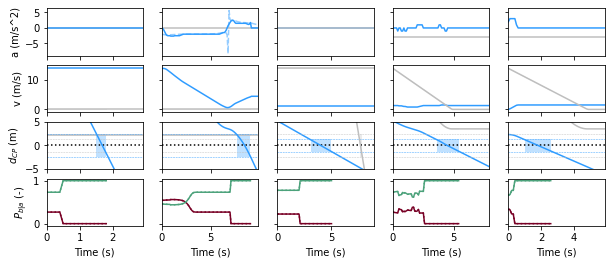

In [4]:
fit = det_fits['oBEvoAI']
idx_best = get_max_crit_parameterisations(fit)
plot_example(fit, idx_example=idx_best[0])

## `oVAoBEvoAI`

Does achieve all of the main criteria, in a quite nice-looking way (but not with enough amplitude in the priority assertion to meet the currently applied threshold for retaining).

{'T_delta': 27.825594022071243, 'beta_V': 10.536102768906645}
{'Vehicle asserting priority': False, 'Vehicle short-stopping': True, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': True}
{'Pedestrian hesitation in constant-speed scenario': False}
*** VehPrioAssert
[13.88888889 13.88888889 13.99465812]
Metric VehPrioAssert_veh_av_speed = 13.994658119658121
*** VehShortStop
[2.61312522 1.82373141 1.4094872 ]
Metric VehShortStop_veh_av_surpl_dec = 2.613125220789506
*** PedHesitateVehConst
[1.3 1.3 1.3]
Metric PedHesitateVehConst_ped_av_speed = 1.3
*** PedHesitateVehYield
[0.37924528 0.31428571 0.26891892]
Metric PedHesitateVehYield_ped_av_speed = 0.268918918918919
*** PedCrossVehYield
[2.21755369 1.64246196 1.30422845]
Metric PedCrossVehYield_veh_speed_at_ped_start = 2.217553688141919


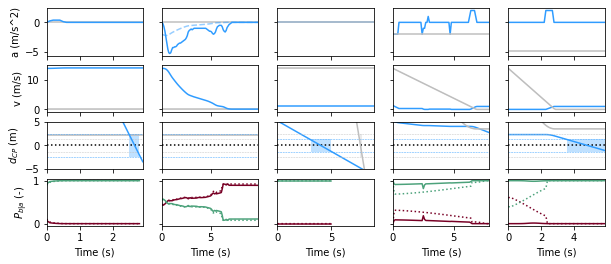

In [5]:
fit = det_fits['oVAoBEvoAI']
idx_best = get_max_crit_parameterisations(fit)
assert_speeds = fit.get_metric_results('VehPrioAssert_veh_av_speed')
assert_max_speeds = np.amax(assert_speeds, axis=1)
idx_max_assert_speed_among_best = np.argmax(assert_max_speeds[idx_best])
idx_example = idx_best[idx_max_assert_speed_among_best]
plot_example(fit, idx_example)

## `oVAoBEo`

Can achieve (very minor) gap acceptance hesitation, but not other phenomena. And the pedestrian now gets stuck without crossing in front of the yielding cars.

[1.13888889 1.18823529 1.21176471]
{'T_delta': 12.91549665014884, 'T_Of': 0.5, 'sigma_O': 1.1989685006378819}
{'Vehicle asserting priority': False, 'Vehicle short-stopping': True, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': False}
{'Pedestrian hesitation in constant-speed scenario': True}
*** VehPrioAssert
[13.88888889 13.79116162 13.39273504]
Metric VehPrioAssert_veh_av_speed = 13.88888888888889
*** VehShortStop
[1.28548164 1.30923079 0.96195905]
Metric VehShortStop_veh_av_surpl_dec = 1.3092307925172784
*** PedHesitateVehConst
[1.13888889 1.18823529 1.21176471]
Metric PedHesitateVehConst_ped_av_speed = 1.1388888888888888
*** PedHesitateVehYield
[0.36545455 0.31230769 0.26710526]
Metric PedHesitateVehYield_ped_av_speed = 0.2671052631578947
*** PedCrossVehYield
[nan nan nan]
Metric PedCrossVehYield_veh_speed_at_ped_start = nan


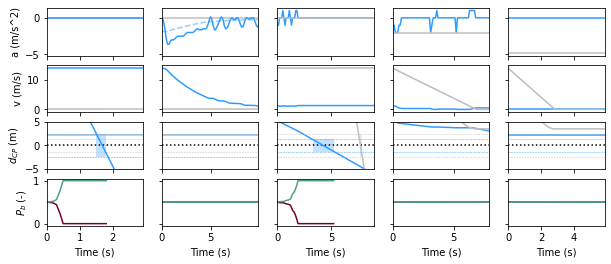

In [6]:
fit = det_fits['oVAoBEo']
idx_example = get_min_ped_hes_speed_example(fit)
plot_example(fit, idx_example)

## `oVAoBEooBEvoAI`

Very similar in behaviour to `oVAoBEvoAI` (with the parameterisation below).

{'T_delta': 27.825594022071243, 'beta_V': 10.536102768906645, 'T_Of': 0.5, 'sigma_O': 0.033362010744001185}
{'Vehicle asserting priority': False, 'Vehicle short-stopping': True, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': True}
{'Pedestrian hesitation in constant-speed scenario': False}
*** VehPrioAssert
[13.88888889 13.88888889 13.99465812]
Metric VehPrioAssert_veh_av_speed = 13.994658119658121
*** VehShortStop
[2.58435049 2.03990283 1.45428489]
Metric VehShortStop_veh_av_surpl_dec = 2.584350492134765
*** PedHesitateVehConst
[1.3 1.3 1.3]
Metric PedHesitateVehConst_ped_av_speed = 1.3
*** PedHesitateVehYield
[0.37924528 0.31746032 0.27297297]
Metric PedHesitateVehYield_ped_av_speed = 0.272972972972973
*** PedCrossVehYield
[2.21755369 1.64246196 1.30422845]
Metric PedCrossVehYield_veh_speed_at_ped_start = 2.217553688141919


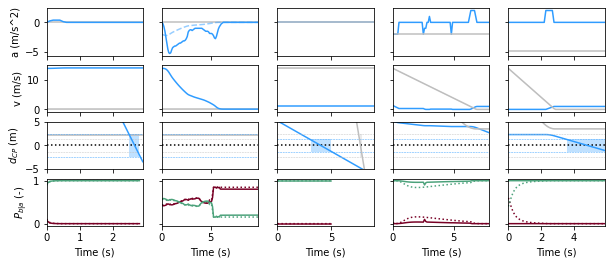

In [7]:
fit = det_fits['oVAoBEooBEvoAI']
idx_best = get_max_crit_parameterisations(fit)
assert_speeds = fit.get_metric_results('VehPrioAssert_veh_av_speed')
assert_max_speeds = np.amax(assert_speeds, axis=1)
idx_max_assert_speed_among_best = np.argmax(assert_max_speeds[idx_best])
idx_example = idx_best[idx_max_assert_speed_among_best]
plot_example(fit, idx_example)

## `oVAoVAloBEooBEvoAI`

The first example below achieves all three main criteria except early yield acceptance - where in fact the model can get consistently stuck, like the `oVAoBEo` model above. I hadn't quite realised this before. 

The second example below achieves all three main criteria except priority assertion (with the current threshold) - there is a small acceleration though. The early gap acceptance shown below looks nice, but note that in one of the kinematic variants the model still gets stuck. I have checked that variant separately, and what happens is that the probability of vehicle second-passing was near to one (like in the simulation below), but then when the vehicle has come to a full stop this probability starts dropping again, presumably at least partly due to the relatively low $T_{Of}$ for this model parameterisation.

{'T_delta': 46.41588833612777, 'thetaDot_1': 0.001, 'beta_V': 1.0, 'T_Of': 0.5, 'sigma_O': 0.25830993300297683}
{'Vehicle asserting priority': True, 'Vehicle short-stopping': True, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': False}
{'Pedestrian hesitation in constant-speed scenario': False}
*** VehPrioAssert
[14.03263889 13.86957071 13.43696581]
Metric VehPrioAssert_veh_av_speed = 14.03263888888889
*** VehShortStop
[1.53536641 1.49273536 1.52794173]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric VehShortStop_veh_av_surpl_dec = 1.5353664136789
*** PedHesitateVehConst
[1.36666667 1.36666667 1.36666667]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric PedHesitateVehConst_ped_av_speed = 1.3666666666666671
*** PedHesitateVehYield
[0.38181818 0.31875    0.27027027]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric PedHesitateVehYield_ped_av_speed = 0.27027027027027034
*** PedCrossVehYield
[nan nan nan]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric PedCrossVehYield_veh_speed_at_ped_start = nan


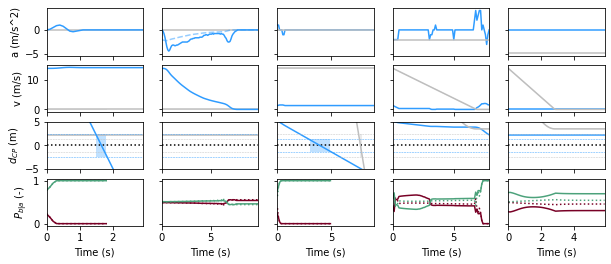

In [8]:
fit = det_fits['oVAoVAloBEooBEvoAI']
idx_best = get_max_crit_parameterisations(fit)
assert_speeds = fit.get_metric_results('VehPrioAssert_veh_av_speed')
assert_max_speeds = np.amax(assert_speeds, axis=1)
idx_max_assert_speed_among_best = np.argmax(assert_max_speeds[idx_best])
idx_example = idx_best[idx_max_assert_speed_among_best]
plot_example(fit, idx_example)

{'T_delta': 100.0, 'thetaDot_1': 0.1, 'beta_V': 1.0, 'T_Of': 0.5, 'sigma_O': 0.020000000000000004}
{'Vehicle asserting priority': False, 'Vehicle short-stopping': True, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': True}
{'Pedestrian hesitation in constant-speed scenario': False}
*** VehPrioAssert
[13.91701389 13.82070707 13.6792735 ]
Metric VehPrioAssert_veh_av_speed = 13.917013888888887
*** VehShortStop
[1.45942243 1.70775899 0.9739859 ]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric VehShortStop_veh_av_surpl_dec = 1.7077589920837204
*** PedHesitateVehConst
[1.3 1.3 1.3]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric PedHesitateVehConst_ped_av_speed = 1.3
*** PedHesitateVehYield
[0.37777778 0.31875    0.27162162]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric PedHesitateVehYield_ped_av_speed = 0.2716216216216216
*** PedCrossVehYield
[2.21755369 1.64246196        nan]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric PedCrossVehYield_veh_speed_at_ped_start = 2.217553688141919


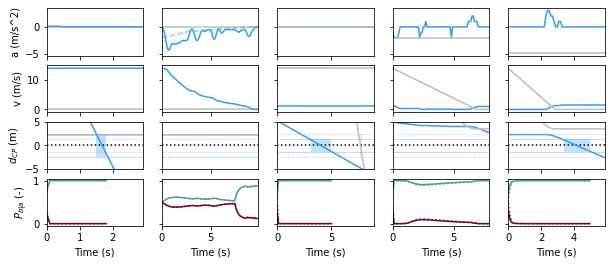

In [9]:
yield_acc_speeds = fit.get_metric_results('PedCrossVehYield_veh_speed_at_ped_start')
max_yield_acc_speeds = np.amax(yield_acc_speeds, axis=1)
idx_max_yield_acc_speed_among_best = np.argmax(max_yield_acc_speeds[idx_best])
idx_example = idx_best[idx_max_yield_acc_speed_among_best]
plot_example(fit, idx_example)

## `oVAaoVAloBEooBEvoAI`

Achieves all four criteria within a single parameterisation, but does so by doing early gap acceptance not quite in the way I intended.

[13.88888889 13.98388889 14.20235043]
{'T_delta': 100.0, 'thetaDot_1': 0.001, 'beta_V': 10.536102768906645, 'T_Of': 5.139042664010977, 'sigma_O': 0.15485273653622542}
{'Vehicle asserting priority': True, 'Vehicle short-stopping': True, 'Pedestrian hesitation in deceleration scenario': True, 'Pedestrian starting before vehicle at full stop': True}
{'Pedestrian hesitation in constant-speed scenario': False}
*** VehPrioAssert
[13.88888889 13.98388889 14.20235043]
Metric VehPrioAssert_veh_av_speed = 14.202350427350428
*** VehShortStop
[ 0.54119602  0.2038005  -0.15394642]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric VehShortStop_veh_av_surpl_dec = 0.5411960223779789
*** PedHesitateVehConst
[1.3 1.3 1.3]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric PedHesitateVehConst_ped_av_speed = 1.3
*** PedHesitateVehYield
[0.28873239        nan 1.52142857]


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Metric PedHesitateVehYield_ped_av_speed = 0.2887323943661972
*** PedCrossVehYield
[ 0.          0.         13.60287388]
Metric PedCrossVehYield_veh_speed_at_ped_start = 13.60287387882116


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


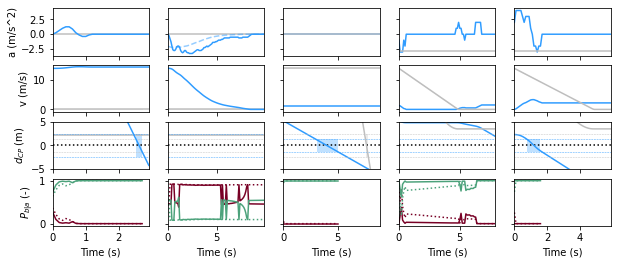

In [10]:
fit = det_fits['oVAaoVAloBEooBEvoAI']
idx_best = get_max_crit_parameterisations(fit)
assert_speeds = fit.get_metric_results('VehPrioAssert_veh_av_speed')
assert_max_speeds = np.amax(assert_speeds, axis=1)
idx_max_assert_speed_among_best = np.argmax(assert_max_speeds[idx_best])
idx_example = idx_best[idx_max_assert_speed_among_best]
print(assert_speeds[idx_example, :])
plot_example(fit, idx_example)

## Conclusions

Overall, looking more closely at the results for the `oVA*oVAloBE*` models, the results are not quite as nice-looking as I thought, and the rules/thresholds I have applied for retaining models and model parameterisations may have carried over some questionable behaviours into the combined fits. I am toying with the idea of lowering the priority assertion threshold for retention, but also requiring that parameterisations don't get stuck in the yield acceptance scenarios. This would get me a different, much smaller set of retained deterministic parameterisations.